In [1]:
import experiment_utils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nds import ndomsort
import pygmo as pg
from sklearn.model_selection import train_test_split
import random
import math

from moopt import monise
from fair_models import FairScalarization, EqualScalarization
from fair_models import SimpleVoting

import copy

In [2]:
data = pd.read_csv("Datasets - Limpos/compas_onerace.csv")
fair_feature = "not_white"
pred_feature = "Two_yr_Recidivism"

In [3]:
categories_fair_class = []

for index, row in data.iterrows():
    if row[pred_feature] == -1:
        categories_fair_class.append(row[fair_feature])
    else:
        categories_fair_class.append(row[fair_feature]+2)

#random_gen = 816
random_gen = random.randint(0, 1000)
print(random_gen)

X = data.drop([pred_feature], axis=1)
y = data[pred_feature]

X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=int(data.shape[0]*0.2),stratify=categories_fair_class,
                                             random_state=random_gen)

ads = [categories_fair_class[i] for i in range(data.shape[0]) if i in X_tv.index.tolist()]
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=int(data.shape[0]*0.2),
                                                  stratify=ads, random_state=random_gen)

514


In [4]:
def nds_moo(models_df, n_selected = 10, with_acc = False):
    models_df['EO'] = -models_df['EO']
    models_df['DP'] = -models_df['DP']
    if 'Acc' in models_df.columns:
        models_df['Acc'] = -models_df['Acc']
    metrics = models_df.values.tolist()

    fronts = ndomsort.non_domin_sort(metrics)
    selected_indexes = []
    for front in fronts:
        hv = pg.hypervolume([list(s) for s in fronts[front]])
        
        if len(selected_indexes)==n_selected:
            break
        
        if len(fronts[front])+len(selected_indexes)<n_selected:
            selected_indexes+=[metrics.index(seq) for seq in fronts[front]]
        else:
            last_front = list(copy.copy(fronts[front]))
            
            nadir = np.max(metrics,axis=0)
            nadir = nadir
            while len(last_front)>n_selected-len(selected_indexes):
                hv = pg.hypervolume([list(s) for s in last_front])
                idx_excl = hv.least_contributor(nadir)
                del last_front[idx_excl]
                
            selected_indexes += [metrics.index(seq) for seq in last_front]
            
    index_list = [models_df.index.tolist()[i] for i in selected_indexes]
    return index_list


def ensemble_from_filtered_models(filtered_models, fair_feature, X_test, y_test):
    # Generate ensemble
    ensemble_model = SimpleVoting(estimators=filtered_models, voting='soft')
    # Evaluate
    metrics = experiment_utils.evaluate_model_test(ensemble_model, fair_feature, X_test, y_test)
    return metrics

def simple_filter(models_df, n_acc, fair_metric, fair_filter):
    if fair_filter:
        n_fair = n_acc//2
        if fair_metric == 'CV':
            index_list = list(models_df.nlargest(n_acc,'Acc').nsmallest(n_fair,fair_metric).index)
        else:
            index_list = list(models_df.nlargest(n_acc,'Acc').nlargest(n_fair,fair_metric).index)
    else:
        index_list = list(models_df.nlargest(n_acc,'Acc').index)
    return index_list

def nds_filter(models_df, n_acc, with_acc):
    models_acc = models_df.nlargest(n_acc,'Acc')
    if not with_acc:
        models_acc = models_acc.drop(['Acc'], axis=1)
    index_list = nds_moo(models_acc, with_acc = with_acc)
    return index_list


def ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc, fair_metric = 'DP', fair_filter = True,
                    nds = False, with_acc = True):
    if nds:
        index_list = nds_filter(models_df, n_acc, with_acc)
    else:
        index_list = simple_filter(models_df, n_acc, fair_metric, fair_filter)
    
    filtered_models = [("Model "+str(i), models_sols[i]) for i in index_list]
    metrics = ensemble_from_filtered_models(filtered_models, fair_feature, X_test, y_test)
    
    if nds:
        if n_acc==150:
            metrics['Filter'] = 'NDS(wAcc)' if with_acc else 'NDS'
        else:
            metrics['Filter'] = str(n_acc)+'Acc+NDS(wAcc)' if with_acc else str(n_acc)+'Acc+NDS'
    else:
        if fair_filter:
            metrics['Filter'] = str(n_acc)+'Acc+'+fair_metric
        else:
            metrics['Filter'] = 'All models' if n_acc==150 else str(n_acc)+'Acc'

    return metrics

def compare_ensembles_fair_metrics(models_df, models_sols, fair_feature, X_test, y_test):
    ensembles_metrics = [
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 150, fair_filter = False),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 75, fair_filter = True, fair_metric='DP'),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 20, fair_filter = True, fair_metric='DP'),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 75, fair_filter = True, fair_metric='EO'),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 20, fair_filter = True, fair_metric='EO'),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 75, fair_filter = True, fair_metric='CV'),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 20, fair_filter = True, fair_metric='CV')
    ]
    results_test = pd.DataFrame(ensembles_metrics)
    results_test = results_test.set_index('Filter')
    return results_test.copy()

def compare_ensembles_nds(models_df, models_sols, fair_feature, X_test, y_test):
    ensembles_metrics = [
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 150, fair_filter = False),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 75, fair_filter = True, fair_metric='DP'),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 20, fair_filter = True, fair_metric='DP'),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 150, nds = True, with_acc=True),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 75, nds = True, with_acc=True),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 20, nds = True, with_acc=True),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 150, nds = True, with_acc=False),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 75, nds = True, with_acc=False),
        ensemble_filter(models_df, models_sols, fair_feature, X_test, y_test, n_acc = 20, nds = True, with_acc=False)
    ]
    results_test = pd.DataFrame(ensembles_metrics)
    results_test = results_test.set_index('Filter')
    return results_test.copy()

# MOOError

In [5]:
## Train 150 models
moo_err = monise(weightedScalar=FairScalarization(X_train, y_train, fair_feature),
                singleScalar=FairScalarization(X_train, y_train, fair_feature),
                nodeTimeLimit=2, targetSize=150,
                targetGap=0, nodeGap=0.05, norm=False)

moo_err.optimize()

## Evaluate the models in val
mooerr_values = []
mooerr_sols = []

for solution in moo_err.solutionsList:
    mooerr_sols.append(solution.x)
    mooerr_values.append(experiment_utils.evaluate_model_test(solution.x, fair_feature, X_val, y_val))

mooerr_df = pd.DataFrame(mooerr_values)

2021-07-20 22:52:34,070 - moopt.monise - DEBUG: Finding 1th individual minima
2021-07-20 22:52:34,100 - moopt.monise - DEBUG: Finding 2th individual minima
2021-07-20 22:52:34,135 - moopt.monise - DEBUG: Finding 3th individual minima
Academic license - for non-commercial use only - expires 2021-08-27
Using license file /Users/vitoriaguardieiro/gurobi.lic
2021-07-20 22:52:34,213 - moopt.monise - DEBUG: 4th solution - importance: 1.0
2021-07-20 22:52:34,270 - moopt.monise - DEBUG: 5th solution - importance: 1.0
2021-07-20 22:52:34,318 - moopt.monise - DEBUG: 6th solution - importance: 1.0
2021-07-20 22:52:34,379 - moopt.monise - DEBUG: 7th solution - importance: 1.0
2021-07-20 22:52:34,432 - moopt.monise - DEBUG: 8th solution - importance: 1.0
2021-07-20 22:52:34,495 - moopt.monise - DEBUG: 9th solution - importance: 0.2892429581448693
2021-07-20 22:52:34,573 - moopt.monise - DEBUG: 10th solution - importance: 0.27688220456621815
2021-07-20 22:52:34,662 - moopt.monise - DEBUG: 11th solut

In [6]:
err_fair_results = compare_ensembles_fair_metrics(mooerr_df, mooerr_sols, fair_feature, X_test, y_test)
err_nds_results = compare_ensembles_nds(mooerr_df, mooerr_sols, fair_feature, X_test, y_test)

In [7]:
## Train 150 models
mooacep = monise(weightedScalar=EqualScalarization(X_train, y_train, fair_feature),
            singleScalar=EqualScalarization(X_train, y_train, fair_feature),
            nodeTimeLimit=2, targetSize=150,
            targetGap=0, nodeGap=0.01, norm=False)

mooacep.optimize()

## Evaluate the models in val
mooacc_values = []
mooacc_sols = []

for solution in mooacep.solutionsList:
    mooacc_sols.append(solution.x)
    mooacc_values.append(experiment_utils.evaluate_model_test(solution.x, fair_feature, X_val, y_val))

mooacep_df = pd.DataFrame(mooacc_values)

2021-07-20 22:54:37,295 - moopt.monise - DEBUG: Finding 1th individual minima
2021-07-20 22:54:37,387 - moopt.monise - DEBUG: Finding 2th individual minima
2021-07-20 22:54:37,427 - moopt.monise - DEBUG: Finding 3th individual minima
2021-07-20 22:54:37,465 - moopt.monise - DEBUG: Finding 4th individual minima
2021-07-20 22:54:37,627 - moopt.monise - DEBUG: 5th solution - importance: 1.0
2021-07-20 22:54:37,705 - moopt.monise - DEBUG: 6th solution - importance: 1.0
2021-07-20 22:54:37,841 - moopt.monise - DEBUG: 7th solution - importance: 1.0
2021-07-20 22:54:37,990 - moopt.monise - DEBUG: 8th solution - importance: 1.0
2021-07-20 22:54:38,080 - moopt.monise - DEBUG: 9th solution - importance: 1.0
2021-07-20 22:54:38,203 - moopt.monise - DEBUG: 10th solution - importance: 0.7049786670029782
2021-07-20 22:54:38,290 - moopt.monise - DEBUG: 11th solution - importance: 0.5520849495362493
2021-07-20 22:54:38,383 - moopt.monise - DEBUG: 12th solution - importance: 0.47080721364489125
2021-07

In [8]:
acep_fair_results = compare_ensembles_fair_metrics(mooacep_df, mooacc_sols, fair_feature, X_test, y_test)
acep_nds_results = compare_ensembles_nds(mooacep_df, mooacc_sols, fair_feature, X_test, y_test)

# Vis

In [9]:
def vis_comp(err_results, acep_results):
    fig, axs = plt.subplots(nrows=2, ncols=4, constrained_layout=True, figsize=(15,6), sharex=True)

    # MOOErr
    err_results['Acc'].plot.bar(ax=axs[0,0], zorder=3)
    axs[0, 0].set_title('Accuracy')
    axs[0, 0].set_ylabel('MOOErr', fontsize=12)
    high_acc = max(err_results['Acc'].max(), acep_results['Acc'].max())
    low_acc = min(err_results['Acc'].min(), acep_results['Acc'].min())
    axs[0, 0].set_ylim([low_acc-0.25*(high_acc-low_acc), high_acc+0.25*(high_acc-low_acc)])

    err_results['DP'].plot.bar(ax=axs[0,1], zorder=3)
    axs[0, 1].set_title('Demographic Parity')
    high_dp = max(err_results['DP'].max(), acep_results['DP'].max())
    low_dp = min(err_results['DP'].min(), acep_results['DP'].min())
    axs[0, 1].set_ylim([low_dp-0.25*(high_dp-low_dp), high_dp+0.25*(high_dp-low_dp)])

    err_results['EO'].plot.bar(ax=axs[0,2], zorder=3)
    axs[0, 2].set_title('Equal Oportunity')
    high_eo = max(err_results['EO'].max(), acep_results['EO'].max())
    low_eo = min(err_results['EO'].min(), acep_results['EO'].min())
    axs[0, 2].set_ylim([low_eo-0.25*(high_eo-low_eo), high_eo+0.25*(high_eo-low_eo)])

    err_results['CV'].plot.bar(ax=axs[0,3], zorder=3)
    axs[0, 3].set_title('Coeficient of Variation')
    high_cv = max(err_results['CV'].max(), acep_results['CV'].max())
    low_cv = min(err_results['CV'].min(), acep_results['CV'].min())
    axs[0, 3].set_ylim([low_cv-0.25*(high_cv-low_cv), high_cv+0.25*(high_cv-low_cv)])

    # MOOAcep
    acep_results['Acc'].plot.bar(ax=axs[1,0], color='red', zorder=3)
    axs[1, 0].set_xlabel('Filter')
    axs[1, 0].set_xticklabels(acep_results.index, rotation=45, ha="right", rotation_mode="anchor")
    axs[1, 0].set_ylabel('MOOAcep', fontsize=12)
    axs[1, 0].set_ylim([low_acc-0.25*(high_acc-low_acc), high_acc+0.25*(high_acc-low_acc)])

    acep_results['DP'].plot.bar(ax=axs[1,1], color='red', zorder=3)
    axs[1, 1].set_xticklabels(acep_results.index, rotation=45, ha="right", rotation_mode="anchor")
    axs[1, 1].set_xlabel('Filter')
    axs[1, 1].set_ylim([low_dp-0.25*(high_dp-low_dp), high_dp+0.25*(high_dp-low_dp)])

    acep_results['EO'].plot.bar(ax=axs[1,2], color='r', zorder=3)
    axs[1, 2].set_xlabel('Filter')
    axs[1, 2].set_xticklabels(acep_results.index, rotation=45, ha="right", rotation_mode="anchor")
    axs[1, 2].set_ylim([low_eo-0.25*(high_eo-low_eo), high_eo+0.25*(high_eo-low_eo)])

    acep_results['CV'].plot.bar(ax=axs[1,3], color='r', zorder=3)
    axs[1, 3].set_xlabel('Filter')
    axs[1, 3].set_xticklabels(acep_results.index, rotation=45, ha="right", rotation_mode="anchor")
    axs[1, 3].set_ylim([low_cv-0.25*(high_cv-low_cv), high_cv+0.25*(high_cv-low_cv)])

    for ax in axs.flatten():
        #ax.xaxis.set_tick_params(labelbottom=True)
        ax.yaxis.set_tick_params(labelleft=True)
        ax.grid(axis='y', color='gray', linestyle='dotted')

    #plt.show()
    return fig, axs

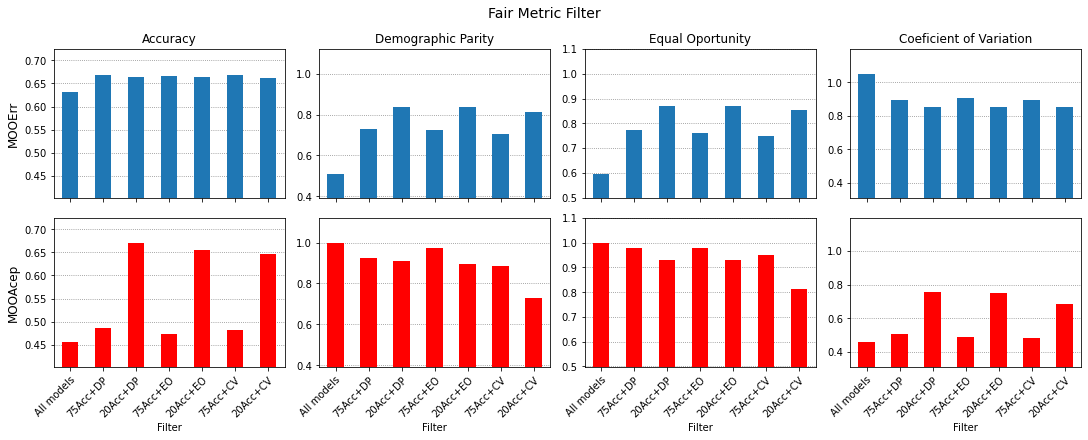

In [10]:
fig, axs = vis_comp(err_fair_results, acep_fair_results)
fig.suptitle('Fair Metric Filter', size=14)
plt.show()

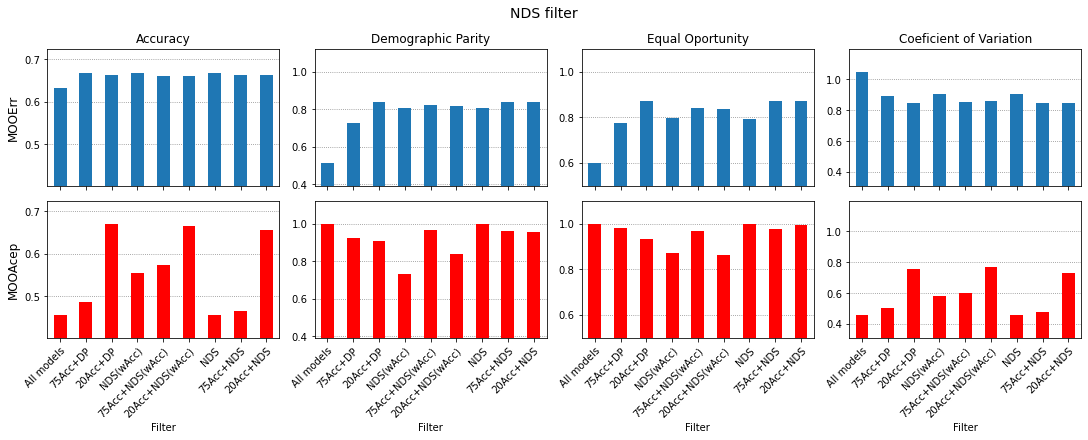

In [11]:
fig, axs = vis_comp(err_nds_results, acep_nds_results)
fig.suptitle('NDS filter', size=14)
plt.show()

In [12]:
err_nds_results

,Acc,EO,DP,CV
Filter,,,,
All models,0.632091,0.597125,0.511485,1.050193
75Acc+DP,0.668558,0.772988,0.728025,0.895255
20Acc+DP,0.663695,0.871331,0.839148,0.850760
NDS(wAcc),0.667747,0.798219,0.808530,0.908213
75Acc+NDS(wAcc),0.662075,0.841626,0.825310,0.855373
20Acc+NDS(wAcc),0.661264,0.835162,0.816803,0.858317
NDS,0.668558,0.794454,0.805742,0.906499
75Acc+NDS,0.663695,0.871331,0.839148,0.850760
20Acc+NDS,0.663695,0.871331,0.839148,0.850760


In [13]:
acep_nds_results

,Acc,EO,DP,CV
Filter,,,,
All models,0.455429,1.000000,1.000000,0.455979
75Acc+DP,0.487034,0.978631,0.926047,0.505318
20Acc+DP,0.670989,0.930567,0.910066,0.758313
NDS(wAcc),0.555916,0.871537,0.730916,0.581579
75Acc+NDS(wAcc),0.574554,0.966103,0.963664,0.600178
20Acc+NDS(wAcc),0.666126,0.860501,0.836379,0.769557
NDS,0.455429,1.000000,1.000000,0.455979
75Acc+NDS,0.465964,0.974811,0.959410,0.480444
20Acc+NDS,0.656402,0.993106,0.955308,0.728959
